# `qubit_discovery` Overview

This notebook will guide you through using the core features of the `qubit_discovery` module, and show you how to put them together to optimize a fluxonium circuit using gradient descent. 

Much of the heavy lifting here is done by [`SQcircuit`](https://sqcircuit.org/), a package for simulating superconducting circuits and calculating gradients using the [`PyTorch`](https://pytorch.org/) engine. This module provides a set of utilities to quickly begin optimization. Before reading this tutorial, familiarize yourself with the basic features of `SQcircuit` [here](https://docs.sqcircuit.org/).

In [1]:
import SQcircuit as sq
import qubit_discovery as qd

# Switch to the PyTorch engine to support gradient and optimization
sq.set_engine('PyTorch')

## Circuit utilities

### Sampling

Optimization begins by choosing a random starting point. The `CircuitSampler` class makes this easy to do based on a range of element values you want to sample between. To match the paper [TODO], let's set the allowable element ranges to:

| Element type       | Minimum value | Maximum value |
|--------------------|---------------|---------------|
| Capacitor          | 1 fF          | 12 pF         |
| Inductor           | 1 fH          | 5 mH          |
| Josephson junction | 1 GHz         | 100 GHz       |

Currently `CircuitSampler` only supports circuits with a single inductive loop. However, you can optimize over that too by passing in an allowed flux range $\subset [0, 1]$.

In [2]:
from qubit_discovery.optimization import CircuitSampler

# Set up a sampler
sampler = CircuitSampler(
    capacitor_range=[1e-15, 12e-12],    # in F
    inductor_range=[1e-15, 5e-6],       # in H
    junction_range=[1e9, 100e9],        # in Hz
    flux_range=[0, 1]                   # in units of Phi_0        
)

The topology of the circuit to be sampled is specified by string called a "**circuit code**." In the case of single-loop circuits, this is a list of the inductive elements present in the loop (`'J'` for Josephson junction and `'L`' for inductor); a more detailed description can be found in the paper [TODO].

For instance, a fluxonium has the circuit code `'JL'`.

In [3]:
# Randomly sample a circuit from the element ranges above…
fluxonium = sampler.sample_circuit_code('JL')
# …and print out the description.
fluxonium.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

### Truncating circuits

To numerically simulate the circuit, the infinite-dimensional Hamiltonian must be truncated. In `SQcircuit`, this is done by choosing truncation numbers for each circuit mode.

In circuits which have multiples modes, it can be difficult to decide how choose truncation numbers. For instance, consider a `'JLL'` circuit, which has two harmonic modes.

TODO: add picture

In [13]:
circuit = sampler.sample_circuit_code('JLL')
circuit.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

As you can see, the first mode has a much higher characteristic frequency, so will participate less strongly in the low-energy modes of the circuit. 

During optimization, we want to constrain the time and memory it takes to diagonalize by fixing a maximum Hilbert space dimension $K$. Without prior knowledge of the circuit, the only reasonable solution is to assign each of the modes of the circuit a truncation number $K^{1/2}$ (so that the total tensor-product Hilbert space has dimension $K$).

In [10]:
K = 750
circuit.set_trunc_nums([int(K**(1/2)), int(K**(1/2))])
print('Truncation numbers', circuit.trunc_nums)
# circuit.check_convergence()

set_trunc_nums called
Truncation numbers [27, 27]


The `qubit_discovery` module offers a function `assign_trunc_nums` which analyzes the circuit to understand which modes are important for the low-energy states, and preferentially assign higher truncation numbers to those modes. It takes in a desired total truncation number (maximum Hilbert space size) $K$ and uses a heuristic method to decide how to allocate truncation numbers to each mode. 

Using this function, circuits can be accurately simulated with a lower $K$ than when assigning each mode an equal truncation number.

In [11]:
circuit.diag(10)
qd.optimization.assign_trunc_nums(circuit, total_trunc_num=K)
print('New truncation numbers', circuit.trunc_nums)
# circuit.check_convergence()

diag called
re-allocate truncation numbers (2+ modes)
set_trunc_nums called
New truncation numbers [5, 145]


## Constructing a loss function

A loss function is built out of a number of component metrics you want to optimize for. The `qubit_discovery.losses` module offers a number of pre-built metrics, which can be accessed with the `get_all_metrics()` function.

In [8]:
qd.losses.get_all_metrics()

['frequency',
 'flux_sensitivity',
 'charge_sensitivity',
 'number_of_gates',
 'anharmonicity',
 'element_sensitivity',
 'gate_speed',
 't',
 't1',
 't1_capacitive',
 't1_inductive',
 't1_quasiparticle',
 't_phi',
 't_phi_charge',
 't_phi_cc',
 't_phi_flux',
 't2',
 't2_charge',
 't2_cc',
 't2_flux']

All the metrics functions are available in the `ALL_METRICS` dictionary; call `help()` on any of them for more details about what a particular loss is.

In [9]:
help(qd.losses.ALL_METRICS['flux_sensitivity'])

Help on function flux_sensitivity_loss in module qubit_discovery.losses.loss:

flux_sensitivity_loss(circuit: SQcircuit.circuit.Circuit, a=0.1, b=1) -> Tuple[Union[float, torch.Tensor], Union[float, torch.Tensor]]
    Applies a hinge loss to flux sensitivity of circuit. The flux sensitivity
    is the normalized variation in qubit frequency for small perturbations of
    the external flux about the operating point. See ``functions.flux_sensitivity``
    for more details.

    Parameters
    ----------
        circuit:
            A ``Circuit`` object specifying the qubit.
        a:
            The cutoff above which to apply the hinge loss.
        b:
            The slope for the hinge loss.

    Returns
    ----------
        loss:
            The hinge loss applied to S.
        S:
            The flux sensitivity of ``circuit``.



After deciding the metrics you want to optimize for, you can build a loss function using the `build_loss_function` constructor. This takes in two inputs
1. The list of metrics you want to optimize for, and the weights in the loss function. The total loss function is then constructed as

$$ \mathcal{L}_\text{tot} = \sum_\text{metrics} \text{weight} \times \mathcal{L}_\text{metric} $$

2. A list of other metrics you want to track during optimization. (For instance, you may only want to optimize for $T_2$ time, but still track what the qubit frequency is.)

Each metric is identified by a name, provided by `get_all_metrics()`.

Below, we'll build a loss function which optimizes for low charge sensitivity, low flux sensitivity, and a large number of single-qubit gates, for simplicity all with the same weight. We'll also track a lot of other properties: $T_1$, $T_\varphi$, $T_2$, and $f_{01}$.

In [4]:
my_loss_function = qd.losses.build_loss_function(
    use_losses = {
        'flux_sensitivity': 1.0,
        'number_of_gates': 1.0
    },
    use_metrics = [
        't1', 
        't_phi',
        't2',
        'frequency',
        'anharmonicity'
    ]
)

## Performing optimization

Now that we've sampled a random circuit and built our loss function, we can perform optimization. Currently, `qubit_discovery` offers two ready-built algorithms: gradient descent and BFGS. These algorithms internally implement the truncation procedures described above.

To optimize the loss function, we'll use BFGS by calling `run_BFGS`. SGD can be run with `run_SGD`, which has the same signature.

In [5]:
optimized_circuit, loss_values, metric_values = qd.optimization.run_BFGS(
    circuit=fluxonium,                          # Starting point
    loss_metric_function=my_loss_function,      # Loss function to optimize
    max_iter=50,                                # Maximum number of iterations
    total_trunc_num=200,                        # Total truncation numbers
    bounds=sampler.bounds                       # Bounds to keep the circuit within during optimization.
)

Iteration 22:  44%|████▍     | 22/50 [02:49<03:35,  7.71s/it, loss=3.941e-05]


We can now look at the details of the optimized circuit

In [6]:
optimized_circuit.description()

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

And track how optimization went using data saved in `loss_record` and `metrics_record`. These are dictionaries which save the metrics you chose to track for each step of optimization.

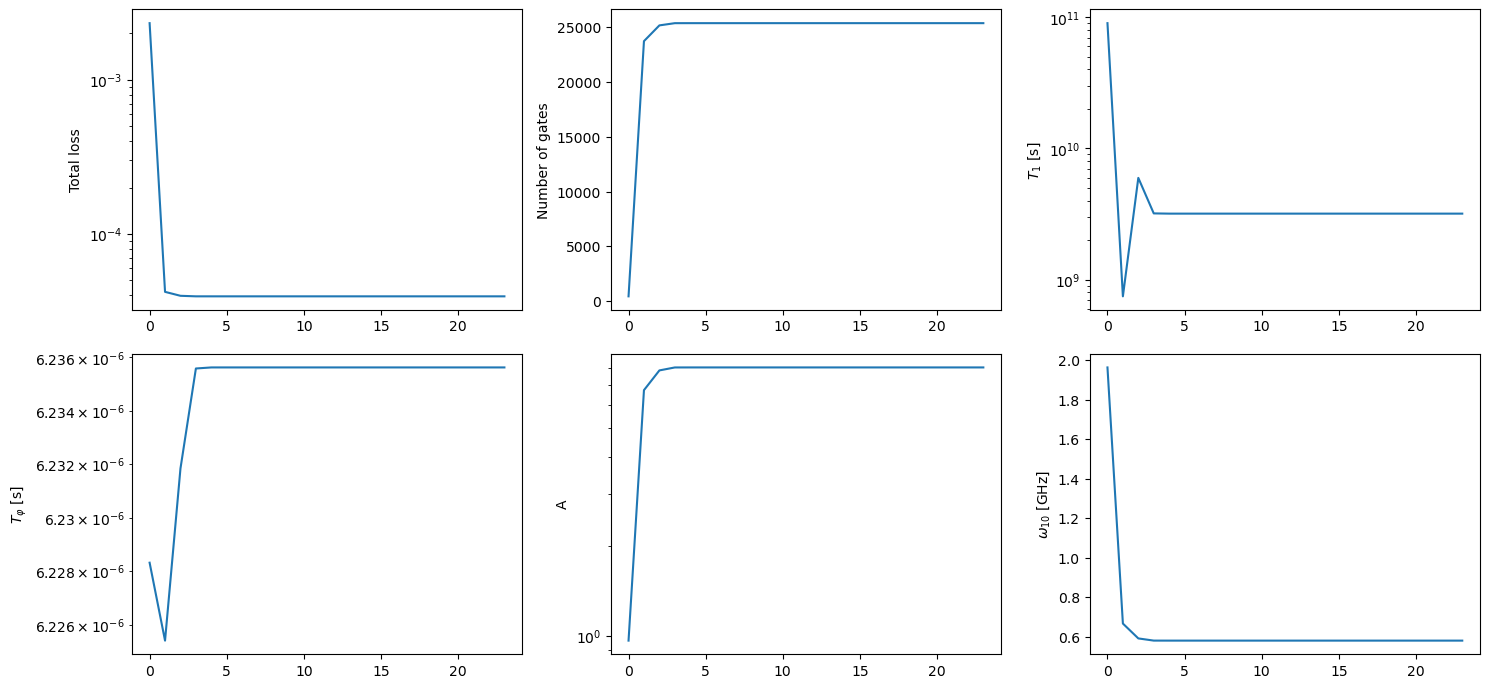

In [8]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2, 3, figsize=(15, 7))

axs[0, 0].semilogy(loss_values['total_loss'])
axs[0, 0].set_ylabel('Total loss')
axs[0,1].plot(metric_values['number_of_gates'])
axs[0, 1].set_ylabel('Number of gates')
axs[0, 2].semilogy(metric_values['t1'])
axs[0, 2].set_ylabel(r'$T_1$ [s]')
axs[1, 0].semilogy(metric_values['t_phi'])
axs[1, 0].set_ylabel(r'$T_\varphi$ [s]')
axs[1, 1].semilogy(metric_values['anharmonicity'])
axs[1, 1].set_ylabel(r'A')
axs[1, 2].plot(metric_values['frequency'])
axs[1, 2].set_ylabel(r'$\omega_{10}$ [GHz]')

fig.tight_layout()